In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [155]:
train = pd.read_csv("data/train.csv", dtype={
        'row_id': 'int64', 
        'timestamp': 'int64', 
        'user_id': 'int32', 
        'content_id': 'int16', 
        'content_type_id': 'int8',
        'task_container_id': 'int16', 
        'user_answer': 'int8', 
        'answered_correctly': 'int8', 
        'prior_question_elapsed_time': 'float32', 
        'prior_question_had_explanation': 'boolean'
    }, nrows=1000000)
print(train.shape)
train.head()

(1000000, 10)


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [156]:
test = pd.read_csv("data/example_test.csv")
test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


## EDA

In [157]:
# 查看缺失值， 数据特征分析略，网站很清楚了，无类别分布不均衡的特征
train.isnull().sum() / len(train)

row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       0.023723
prior_question_had_explanation    0.003816
dtype: float64

In [158]:
# 查看各特征的unique values
columns = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation']

for col in columns:
    print("{}特征有: {}个不同的值".format(col, train[col].nunique()))

row_id特征有: 1000000个不同的值
timestamp特征有: 769357个不同的值
user_id特征有: 3824个不同的值
content_id特征有: 13320个不同的值
content_type_id特征有: 2个不同的值
task_container_id特征有: 7740个不同的值
user_answer特征有: 5个不同的值
answered_correctly特征有: 3个不同的值
prior_question_elapsed_time特征有: 1659个不同的值
prior_question_had_explanation特征有: 2个不同的值


answered_correctly             1.000000
user_answer                    0.126721
task_container_id              0.039130
timestamp                      0.027571
prior_question_elapsed_time    0.003251
user_id                       -0.014776
row_id                        -0.015589
content_id                    -0.203327
content_type_id               -0.438788
Name: answered_correctly, dtype: float64


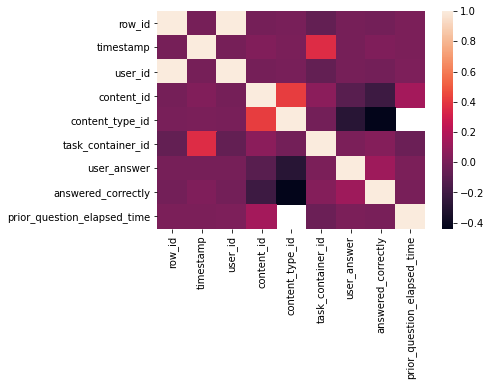

In [159]:
#划分数值特征和类别特征
numerical_feat = ['row_id', 'timestamp', 'user_id', 'content_id', 'task_container_id', 'prior_question_elapsed_time']
categorical_feat = ['content_type_id', 'user_answer', 'answered_correctly', 'prior_question_had_explanation']

# 对数据进行特征相关性
numeric = train[columns]
print(numeric.corr()['answered_correctly'].sort_values(ascending=False)) # 各特征与回答正确与否的相关性
sns.heatmap(numeric.corr()) # 各特征之间的相关性

一组有意义的相关性较高的特征：
"task_container_id" is correlated with the "timestamp".
也许是某些特定question组合成的某个task_container_id总是出现在呈现给学生的题库的特定位置(基础题总是出现在头几道题)

至于"content_type_id"和"answered_correctly"的负相关，我觉得是因为当content_type_id = 1(lecture)时, answered_correctly总为-1
content_type_id: 0代表question, 1代表lecture.

### 分析特征根据timestamp的变化特点

Text(0, 0.5, 'mean value of answered_correctly')

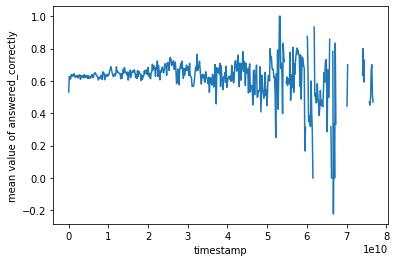

In [229]:
# 随着时间变化答题的准确度
length = len(train)
tmp_df = train[['timestamp', 'answered_correctly']].sort_values(by='timestamp', ascending=True)

intervals = (tmp_df['timestamp'].max() - tmp_df['timestamp'].min()) / 500
bins = list(np.arange(tmp_df['timestamp'].min() - 1, tmp_df['timestamp'].max(), intervals))
df = pd.DataFrame(pd.cut(tmp_df['timestamp'], bins=bins))
df['answered_correctly'] = tmp_df['answered_correctly']
bins.pop()

changes = np.array(df.groupby("timestamp").agg("mean"))
plt.plot(bins, changes)
plt.xlabel("timestamp")
plt.ylabel("mean value of answered_correctly")

随着时间增加，准确率略有提升但总体不太受影响

Text(0, 0.5, 'mean value of task_container_id')

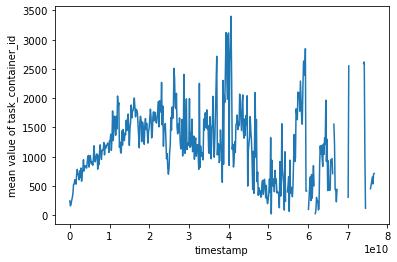

In [230]:
# 随着时间变化task_container_id的变化
length = len(train)
tmp_df = train[['timestamp', 'task_container_id']].sort_values(by='timestamp', ascending=True)

intervals = (tmp_df['timestamp'].max() - tmp_df['timestamp'].min()) / 500
bins = list(np.arange(tmp_df['timestamp'].min() - 1, tmp_df['timestamp'].max(), intervals))
df = pd.DataFrame(pd.cut(tmp_df['timestamp'], bins=bins))
df['task_container_id'] = tmp_df['task_container_id']
bins.pop()

changes = np.array(df.groupby("timestamp").agg("mean"))
plt.plot(bins, changes)
plt.xlabel("timestamp")
plt.ylabel("mean value of task_container_id")

题目似乎是按照相对固定的题号出现的呢~

Text(0, 0.5, 'mean value of prior_question_elapsed_time')

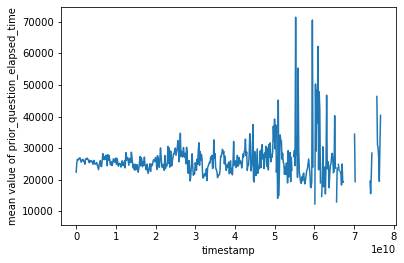

In [231]:
# 随着时间变化prior_question_elapsed_time的变化
length = len(train)
tmp_df = train[['timestamp', 'prior_question_elapsed_time']].sort_values(by='timestamp', ascending=True)

intervals = (tmp_df['timestamp'].max() - tmp_df['timestamp'].min()) / 500
bins = list(np.arange(tmp_df['timestamp'].min() - 1, tmp_df['timestamp'].max(), intervals))
df = pd.DataFrame(pd.cut(tmp_df['timestamp'], bins=bins))
df['prior_question_elapsed_time'] = tmp_df['prior_question_elapsed_time']
bins.pop()

changes = np.array(df.groupby("timestamp").agg("mean"))
plt.plot(bins, changes)
plt.xlabel("timestamp")
plt.ylabel("mean value of prior_question_elapsed_time")

题目做久了做题时间略有增加，但似乎也没想着着急提交

### 分析特征根据user_id的变化特点

       task_container_id
count        3824.000000
mean          261.506276
std           707.047994
min             1.000000
25%            30.000000
50%            41.500000
75%           158.250000
max         10826.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002139C274088>]],
      dtype=object)

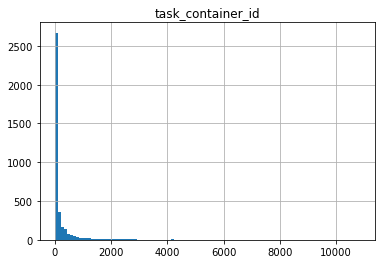

In [178]:
# user_id的答题数量分布
user_task_df = train.groupby("user_id").agg({"task_container_id": "count"})
print(user_task_df.describe())
user_task_df.hist(bins=100)

将近一半人做题数量不足50题

        timestamp
count    0.000044
mean    61.929512
std    124.010474
min      0.000000
25%      0.013075
50%      4.055391
75%     58.223320
max    903.842553


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002139C855588>]],
      dtype=object)

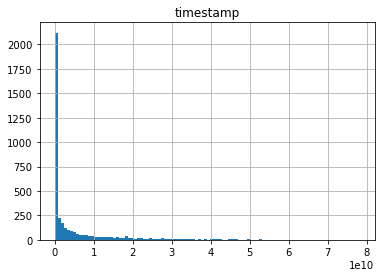

In [181]:
# user_id使用软件时长分布
user_task_df = train.groupby("user_id").agg({"timestamp": "max"})
print(user_task_df.describe() /(1000 * 3600 * 24))
user_task_df.hist(bins=100)

一般用户使用软件仅能坚持4天，居然有人恐怖得坚持了900天。。。

In [273]:
# 利用答题正确率筛选一下优秀用户
score_correct_df = copy.deepcopy(train[["user_id", "answered_correctly"]])

score_correct_df = score_correct_df[score_correct_df["answered_correctly"] != -1]# 筛去content为lecture
corret_rate_df = pd.DataFrame(score_correct_df.groupby("user_id").sum()
           / score_correct_df.groupby("user_id").count()).sort_values(by="answered_correctly", ascending=False)

best_correct_rate_users = set(corret_rate_df[: 500].index)
print("正确率最高的用户", best_correct_rate_users)

正确率最高的用户 {8284166, 16461833, 18673677, 18464784, 7378974, 19040288, 15863849, 12634156, 16005177, 1546298, 20013125, 1544271, 5367887, 5103696, 15388756, 15632472, 14944351, 20566119, 9199721, 6430826, 17645675, 9322612, 8859766, 20787321, 17582209, 8007810, 7051394, 19087497, 10025098, 19376267, 9904267, 11276433, 3637398, 7428249, 19843227, 10135708, 1298591, 1724578, 15093922, 3254436, 7661733, 18045095, 1962155, 1880240, 8786105, 4368578, 14842055, 3897551, 11817171, 11610328, 7358682, 16314590, 12982499, 17397989, 10580203, 9361644, 2212092, 8124670, 16240897, 3838215, 459017, 2963722, 15892752, 1024273, 12579104, 2953506, 12110119, 15343921, 20566324, 3914038, 9658680, 3502397, 19024189, 12730696, 4479305, 13637966, 2738513, 16537938, 1534292, 8208725, 5161303, 2718040, 10115419, 8425831, 2695529, 2136430, 7305583, 18190705, 3676531, 15182202, 8419707, 6566272, 7774594, 18225541, 2724232, 9656713, 7807373, 17019278, 6846873, 16202138, 3242395, 2916765, 15253920, 4108706, 7788970,

In [274]:
# 利用做题数量筛选一下优秀用户
task_number_df = copy.deepcopy(train[["user_id", "task_container_id"]])

df = pd.DataFrame(task_number_df.groupby("user_id").count()).sort_values(by="task_container_id", ascending=False)
most_task_number_users = set(df[: 500].index)
print("做题数最多的用户", most_task_number_users)

做题数最多的用户 {5941252, 4734982, 8284166, 9793549, 18673677, 8450063, 15052813, 13907981, 5087251, 12793875, 20172821, 2547741, 16590885, 3270696, 6146089, 4417578, 12718123, 1533993, 7792680, 12290099, 15622198, 6588478, 2433088, 10229827, 4964431, 5103696, 15388756, 18051158, 17025111, 15632472, 12273755, 11702371, 712805, 20566119, 9199721, 16586857, 17645675, 20895849, 8855664, 1534072, 20787321, 10860665, 17741947, 19935354, 9863292, 5365886, 7051394, 141455, 7166099, 9373844, 3637398, 15956125, 15093922, 3254436, 12497062, 18122922, 2121898, 1962155, 8087726, 1108148, 7964858, 9187517, 20646079, 9498821, 20123845, 19771602, 11817171, 4135123, 11610328, 7358682, 16314590, 5521635, 3680487, 7876847, 8534262, 19441925, 3838215, 459017, 1024273, 16181535, 3016994, 13822254, 18643247, 12730696, 13637966, 16537938, 11637089, 7305583, 8419707, 12439940, 10353031, 2724232, 1765772, 7807373, 1657235, 9097620, 2916765, 11084192, 16253345, 4108706, 15669681, 8567217, 8808883, 10611132, 4663746, 

In [275]:
# 利用使用软件时间筛选一下优秀用户
duration_df = copy.deepcopy(train[["user_id", "timestamp"]])

df = pd.DataFrame(duration_df.groupby("user_id").max()).sort_values(by="timestamp", ascending=False)
longest_duration_users = set(df[: 500].index)
print("使用软件时间最长的用户", longest_duration_users)

使用软件时间最长的用户 {15757313, 11161602, 18673677, 13907981, 8450063, 12793875, 4624404, 20172821, 20543516, 15099932, 1533993, 12718123, 17412142, 12290099, 6996029, 9322570, 4964431, 17025111, 12273755, 11702371, 2627685, 20566119, 17045609, 3297385, 2726001, 14284916, 20787321, 19935354, 10860665, 17741947, 5365886, 839808, 7051394, 10379395, 2257029, 16001159, 9373844, 3637398, 13328543, 18774176, 1724578, 12497062, 18122922, 1962155, 2121898, 8087726, 18802864, 12671153, 1108148, 11450549, 8786105, 9187517, 9498821, 15216842, 19771602, 4135123, 20312279, 11610328, 5521635, 13285606, 3680487, 12644586, 8745203, 8534262, 2019581, 19441925, 14491910, 3838215, 16316678, 15812898, 20521275, 2601277, 13637966, 16537938, 4247900, 17664352, 20615524, 7305583, 2799989, 10873212, 13277570, 7774594, 19691910, 9097620, 6556061, 8061341, 6164893, 11084192, 13638051, 7825839, 8808883, 4663746, 17174979, 4719044, 6078930, 4508124, 19655135, 8858084, 6431206, 6935015, 6619628, 6699502, 15903215, 4727295,

In [300]:
#取三个标准下的交集就是最好的用户
best_users = list(best_correct_rate_users & most_task_number_users & longest_duration_users)
best_users_df = train[train["user_id"].isin(best_users)]
best_users_df.groupby("user_id").agg({"task_container_id": "count"}).describe()

,task_container_id
count,53.000000
mean,2165.566038
std,1837.553375
min,426.000000
25%,709.000000
50%,1527.000000
75%,2508.000000
max,7569.000000


优秀的学生50%的人能做到1500题，大多数能做到700题以上

### 分析特征根据content_id的变化特点

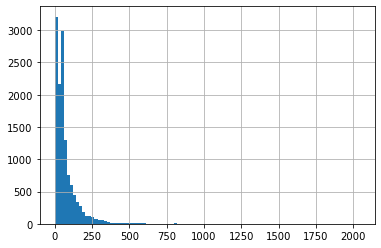

In [315]:
#不同问题的出现频次
content_df = copy.deepcopy(train[train["answered_correctly"] != -1]) # 筛选掉lectures
grouped_by_content_df = content_df.groupby("content_id").agg({"answered_correctly": ['mean', 'count'] })

grouped_by_content_df[('answered_correctly','count')].hist(bins=100)

大部分题目出现在200次以内

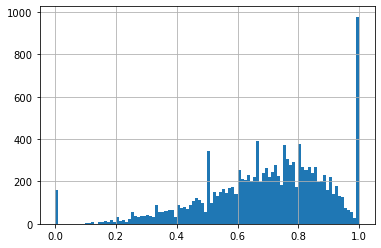

In [316]:
#不同问题的难度
grouped_by_content_df[('answered_correctly','mean')].hist(bins=100)

少部分题目正确率相当高，总体和实际情况相符

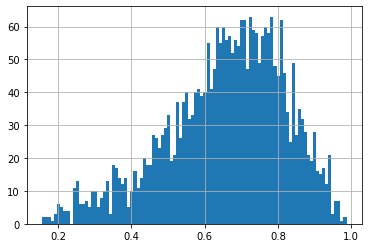

In [319]:
#高频题的难度情况(出现100次以上)
grouped_by_content_df[grouped_by_content_df[('answered_correctly','count')]>100][('answered_correctly','mean')].hist(bins = 100)

In [ ]:
后面可以清洗一下少量含nan的数据，再变换一下某些数据，再特征选择